## 4번 예측

### 목차

- 1. 데이터 탐색
- 2. 전처리
- 3. 인코딩
- 4. 모델 학습
 - 4.1 XGBoost Classifier
- 5. 평가

### 결과 표

In [541]:
pd.read_csv('result_df', index_col=0)

,XGBoost Classifier
사용 모델,XGBoost Classifier
Eval Metric,logloss
학습 시간,4s
학습 반복 수,410 rounds
Learning Rate,0.01
Early Stopping,Y
Scaling,N
StratifiedKFold(n_splits),Y (5)
---------------Train--------------,-------------------Train------------------
학습 데이터 수,37629


### 1. 데이터 탐색

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
person_df = pd.read_csv('db/person.csv')
visit_occurrence_df = pd.read_csv('db/visit_occurrence.csv')
condition_occurrence_df = pd.read_csv('db/condition_occurrence.csv')
drug_exposure_df = pd.read_csv('db/drug_exposure.csv')
death_df = pd.read_csv('db/death.csv')

In [3]:
print("환자 수:", len(person_df.loc[:,'person_id'].unique()))
print("진단명의 종류:", len(condition_occurrence_df.loc[:,'condition_concept_id'].unique()))
print("처방 의약품의 종류:", len(drug_exposure_df.loc[:,'drug_concept_id'].unique()))

환자 수: 1000
진단명의 종류: 151
처방 의약품의 종류: 164


In [4]:
print("각 방문당 의약품 처방 count 통계(의약품 처방 정보이기 때문에 0은 기록X)")
drug_exposure_df.groupby(by='visit_occurrence_id')['drug_concept_id'].count().describe()

각 방문당 의약품 처방 count 통계(의약품 처방 정보이기 때문에 0은 기록X)


count    26175.000000
mean         1.779522
std          1.407180
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: drug_concept_id, dtype: float64

In [5]:
print("의약품 처방 데이터에서의 방문id 종류:", len(drug_exposure_df.loc[:,'visit_occurrence_id'].unique()))
print("방문 데이터에서의 방문id 종류:", len(visit_occurrence_df.loc[:,'visit_occurrence_id'].unique()))

의약품 처방 데이터에서의 방문id 종류: 26175
방문 데이터에서의 방문id 종류: 41810


In [6]:
print("각 방문당 진단(병명) count 통계")
condition_occurrence_df.groupby(by='visit_occurrence_id')['condition_concept_id'].count().describe()

각 방문당 진단(병명) count 통계


count    7365.000000
mean        1.652003
std         1.665995
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        13.000000
Name: condition_concept_id, dtype: float64

In [7]:
print("진단 데이터에서의 방문id 종류:", len(condition_occurrence_df.loc[:,'visit_occurrence_id'].unique()))
print("방문 데이터에서의 방문id 종류:", len(visit_occurrence_df.loc[:,'visit_occurrence_id'].unique()))

진단 데이터에서의 방문id 종류: 7365
방문 데이터에서의 방문id 종류: 41810


In [8]:
print("입원 유형 방문:", len(visit_occurrence_df.loc[visit_occurrence_df['visit_concept_id']==9201]))
print("외래 유형 방문:", len(visit_occurrence_df.loc[visit_occurrence_df['visit_concept_id']==9202]))
print("응급 유형 방문:", len(visit_occurrence_df.loc[visit_occurrence_df['visit_concept_id']==9203]))

입원 유형 방문: 1309
외래 유형 방문: 37026
응급 유형 방문: 3475


In [9]:
visit_occurrence_df_copy = visit_occurrence_df.loc[:,['person_id','visit_occurrence_id','visit_concept_id','visit_end_datetime']].sort_values(by=['person_id','visit_end_datetime']).reset_index()
visit_occurrence_df_copy.head(20)

,index,person_id,visit_occurrence_id,visit_concept_id,visit_end_datetime
0,28960,2955,57618647,9202,1987-05-11 14:13:53
1,28961,2955,57618653,9202,2009-03-30 13:43:53
2,28962,2955,57618648,9202,2011-03-05 13:43:53
3,28963,2955,57618654,9202,2011-04-04 13:58:53
4,28964,2955,57618655,9202,2013-04-08 13:43:53
5,28965,2955,57618650,9202,2015-04-02 13:50:53
6,28966,2955,57618656,9202,2015-04-13 13:58:53
7,28967,2955,9251643,9203,2015-04-20 13:43:53
8,28968,2955,9251642,9203,2016-07-24 15:58:53
9,28969,2955,57618651,9202,2016-08-23 13:43:53


In [10]:
# 시작 날짜와 종료 날짜를 입력하면 차이를 days(시간 소수점 포함) 단위로 계산합니다.
def calcDays(start_time, end_time):
    start_time_dt = dt.datetime.strptime(start_time[:-3], "%Y-%m-%d %H:%M")
    end_time_dt = dt.datetime.strptime(end_time[:-3], "%Y-%m-%d %H:%M")
    return (end_time_dt - start_time_dt).days + round((end_time_dt - start_time_dt).seconds/86400, 2)

In [418]:
# 30일 이내 응급실 방문한 환자 수를 구합니다.
# 환자id, 방문 종료날짜 순으로 정렬, index_reset()을 합니다.
visit_occurrence_df_copy = visit_occurrence_df.loc[:,['person_id','visit_occurrence_id','visit_concept_id','visit_end_datetime']].sort_values(by=['person_id','visit_end_datetime']).reset_index()
unique_person_id = visit_occurrence_df_copy.loc[:,'person_id'].unique()
er_visit_count = 0
er_visit_idx = [] # 30일 이내 방문 한 방문id 리스트
for trg_person_id in unique_person_id:
    visit_occurrence_df_by_person = visit_occurrence_df_copy.loc[visit_occurrence_df_copy['person_id']==trg_person_id].copy().reset_index()
    for line in visit_occurrence_df_by_person.iterrows():
        if line[1]['visit_concept_id'] == 9203 and not line[0]-1 < 0:
            prev_visit_datetime = visit_occurrence_df_by_person.loc[line[0]-1,'visit_end_datetime']
            trg_visit_datetime = line[1]['visit_end_datetime']
            if calcDays(prev_visit_datetime, trg_visit_datetime) <= 30: # 이전 방문 날짜가 30이하일 경우
                er_visit_count += 1
                er_visit_idx.append(visit_occurrence_df_by_person.loc[line[0]-1,'visit_occurrence_id'])
er_visit_count

2293

In [12]:
# 방문 종료 일시, 진단 시작 일시, 진단 종료 일시
# 방문이 종료된 시점에 갖고있는 병명 확인에 사용될 함수
def checkConditionConcept(visit_end_datetime, condition_start_datetime, condition_end_datetime):
    if isinstance(condition_end_datetime, float) and np.isnan(condition_end_datetime):
        return False
    return calcDays(visit_end_datetime, condition_start_datetime) < 0 and calcDays(visit_end_datetime, condition_end_datetime) > 0

In [413]:
# 데이터를 쉽게 찾을수 있도록 각 타겟 id를 index로 변경합니다.
visit_occurrence_df_by_visit_occurrence_id = visit_occurrence_df.copy().set_index('visit_occurrence_id')

In [419]:
# 30일 이내 응급실을 방문한 환자가 방문 종료 당시 갖고있는 질병과 그 수를 구합니다.
er_visit_condition_count = {}
for line in visit_occurrence_df_by_visit_occurrence_id.loc[er_visit_idx].iterrows():
    # 방문 데이터 중 환자 별로 데이터를 조회합니다.
    condition_occurrence_df_copy = condition_occurrence_df.loc[condition_occurrence_df['person_id']==line[1]['person_id']].copy()
    condition_list = condition_occurrence_df_copy.apply(
        lambda x: x['condition_concept_id'] if checkConditionConcept(line[1]['visit_end_datetime'], x['condition_start_datetime'], x['condition_end_datetime']) else 0,
        axis=1
    )
    for cond in condition_list:
        if cond in er_visit_condition_count:
            er_visit_condition_count[cond] += 1
        else:
            er_visit_condition_count[cond] = 1
er_visit_condition_count

{0: 42316,
 260139: 156,
 254761: 11,
 437663: 14,
 4089228: 8,
 37311061: 15,
 4112343: 65,
 40481087: 129,
 4217975: 244,
 137613: 18,
 40479422: 1,
 77074: 2,
 255848: 1,
 319049: 1,
 442752: 2,
 4158346: 1,
 4223659: 3,
 4289517: 5,
 4283893: 33,
 199076: 1,
 439393: 16,
 4294548: 34,
 4285898: 2,
 439777: 24,
 28060: 12,
 378253: 6,
 434490: 4,
 440086: 3,
 4051466: 8,
 40486433: 4,
 4195085: 1,
 312437: 2,
 314754: 2,
 4035415: 1,
 134438: 1,
 4237458: 6,
 372328: 2,
 133834: 8,
 4145808: 1,
 4152936: 1,
 4134304: 4,
 81151: 4,
 4142905: 2,
 4116491: 1,
 40479768: 3,
 78272: 1,
 195588: 1,
 4048171: 1,
 257012: 1,
 4156265: 1}

In [420]:
# 정렬 후 top20 출력
sorted_er_visit_condition_count = sorted(er_visit_condition_count.items(), key=lambda x: -x[1])
sorted_er_visit_condition_count[:20]

[(0, 42316),
 (4217975, 244),
 (260139, 156),
 (40481087, 129),
 (4112343, 65),
 (4294548, 34),
 (4283893, 33),
 (439777, 24),
 (137613, 18),
 (439393, 16),
 (37311061, 15),
 (437663, 14),
 (28060, 12),
 (254761, 11),
 (4089228, 8),
 (4051466, 8),
 (133834, 8),
 (378253, 6),
 (4237458, 6),
 (4289517, 5)]

In [421]:
# 30일 이내 응급실을 방문한 환자가 방문 종료 당시 처방 돼 있는 약과 그 수를 구합니다.
er_visit_drug_count = {}
for line in visit_occurrence_df_by_visit_occurrence_id.loc[er_visit_idx].iterrows():
    # 방문 데이터 중 환자 별로 데이터를 조회합니다.
    drug_exposure_df_copy = drug_exposure_df.loc[drug_exposure_df['person_id']==line[1]['person_id']].copy()
    drug_list = drug_exposure_df_copy.apply(
        lambda x: x['drug_concept_id'] if checkConditionConcept(line[1]['visit_end_datetime'], x['drug_exposure_start_datetime'], x['drug_exposure_end_datetime']) else 0,
        axis=1
    )
    for drug in drug_list:
        if drug in er_visit_drug_count:
            er_visit_drug_count[drug] += 1
        else:
            er_visit_drug_count[drug] = 1
er_visit_drug_count

{0: 1431080,
 40229134: 36,
 1539463: 437,
 40163924: 431,
 19127663: 494,
 19078461: 11,
 1127433: 184,
 1511248: 83,
 40224172: 293,
 40169216: 83,
 19106768: 21,
 19009384: 1457,
 1713671: 44,
 40169281: 20,
 19078106: 471,
 19129144: 2,
 19128009: 5,
 19126352: 585,
 1539411: 497,
 1332419: 496,
 19075601: 476,
 19074679: 2,
 19133679: 4,
 40224805: 8,
 19133873: 2,
 40171902: 205,
 19018935: 205,
 40163554: 205,
 19127918: 1,
 19133905: 12,
 40165015: 1,
 1115171: 14,
 46221626: 2,
 40221415: 2,
 1519937: 7,
 1718701: 1,
 40162606: 2,
 19077572: 7,
 19073183: 1,
 19079924: 1,
 19127904: 2,
 40231925: 3,
 40236824: 2,
 920300: 2,
 723042: 1,
 19128263: 1,
 40162522: 3,
 40223768: 1,
 19132304: 2,
 836659: 1,
 1101556: 1,
 1167323: 1,
 44816277: 1}

In [422]:
# 정렬 후 top20 출력
sorted_er_visit_drug_count = sorted(er_visit_drug_count.items(), key=lambda x: -x[1])
sorted_er_visit_drug_count[:20]

[(0, 1431080),
 (19009384, 1457),
 (19126352, 585),
 (1539411, 497),
 (1332419, 496),
 (19127663, 494),
 (19075601, 476),
 (19078106, 471),
 (1539463, 437),
 (40163924, 431),
 (40224172, 293),
 (40171902, 205),
 (19018935, 205),
 (40163554, 205),
 (1127433, 184),
 (1511248, 83),
 (40169216, 83),
 (1713671, 44),
 (40229134, 36),
 (19106768, 21)]

In [423]:
np.array(sorted_er_visit_drug_count[1:10])[:,1].sum()

5344

*결론*
- *환자 수: __1000__*
- *진단명의 종류: __151__*
- *처방 의약품의 종류: __164__*
- *방문데이터 중 의약품 처방 데이터는 약 __62%__만 존재*
- *의약품 처방 데이터 중 한번 방문에서 처방된 의약품은 __최대 15개 평균 1.8개__ 존재*
- *방문 데이터 중 진단 데이터는 약 __18%__만 존재 (한번 진단된 병명은 종료 날짜까지 계속 병을 갖고있을 것으로 추정)*
- *진단 데이터 중 한번 방문에서 진단명은 최대 __13개 평균 1.7개__ 존재*
- *입원 유형 방문: __1309 (약 3%)__*
- *외래 유형 방문: __37026 (약 89%)__*
- *응급 유형 방문: __3475 (약 8%)__*
- *방문 후 30일 이내(30 포함)에 응급 방문 수: __2293 (전체 중 약 5% 응급 중 약 66%)__*
- *방문 후 30일 이내에 응급 방문 한 환자들이 앓고있는 질병 중 top6 질병(이하 top6 질병): __4217975, 260139, 40481087, 4112343, 4294548, 4283893__*
- *top6 질병의 count 합계: __661__*
- *방문 후 30일 이내에 응급 방문 한 환자들에게 처방 돼 있는 top9 의약품(이하 top9 의약품): __19009384, 19126352, 1539411, 1332419, 19127663, 19075601, 19078106, 1539463, 40163924__*
- *top9 의약품의 count 합계: __5344__*

### 2. 전처리

In [19]:
# 필요한 정보를 담을 DataFrame
preprosessed_df = pd.DataFrame()

- 기본 feature

In [20]:
# 데이터를 쉽게 찾을수 있도록 각 타겟 id를 index로 변경합니다.
person_df_by_person_id = person_df.copy().set_index('person_id')

In [21]:
# 방문id, 환자id, 방문 유형, 방문 시작 일시, 방문 종료 일시
preprosessed_df = visit_occurrence_df.loc[:,['visit_occurrence_id','person_id','visit_concept_id','visit_start_datetime','visit_end_datetime']].copy()

# 방문 기간(days)
preprosessed_df.loc[:,'visit_days'] = visit_occurrence_df.loc[:,['visit_start_datetime','visit_end_datetime']].apply(
    lambda x: calcDays(x['visit_start_datetime'], x['visit_end_datetime']),
    axis=1
)

# 성별
preprosessed_df.loc[:,'gender_concept_id'] = person_df_by_person_id.loc[visit_occurrence_df['person_id'],'gender_concept_id'].values

In [22]:
# 방문 종료 당시 나이
visit_age_list = []
for line in visit_occurrence_df.iterrows():
    visit_end_datetime = line[1]['visit_end_datetime']
    birth_datetime = person_df.loc[person_df['person_id']==line[1]['person_id'],'birth_datetime'].values[0]
    visit_age_list.append(round(calcDays(birth_datetime, visit_end_datetime)/365,1))
preprosessed_df.loc[:,'visit_age'] = np.array(visit_age_list).astype(np.float64)

In [23]:
# 약 5분 소요
# 진단(병명) 수 => 방문 종료 당시 갖고 있는 병명의 수
condition_count_list = []
for line in visit_occurrence_df.iterrows():
    condition_occurrence_df_copy = condition_occurrence_df.loc[condition_occurrence_df['person_id']==line[1]['person_id']].copy()
    condition_count = 0
    if not len(condition_occurrence_df_copy) == 0: # 진단에 환자id가 존재하지 않는다면 0
        condition_count = condition_occurrence_df_copy.apply(
            lambda x: 1 if checkConditionConcept(line[1]['visit_end_datetime'], x['condition_start_datetime'], x['condition_end_datetime']) else 0,
            axis=1
        ).sum()
    condition_count_list.append(condition_count)
preprosessed_df.loc[:,'condition_concept_count'] = np.array(condition_count_list).astype(np.int64)


In [24]:
# 약 5분 소요
# 방문 종료 당시 top6 질병을 갖고있는 환자 (y: 1,n: 0)
top6_disease_list = [260139, 40481087, 4217975, 4112343, 4283893, 4294548]
top6_check_list = [] # (y: 1,n: 0)
for line in visit_occurrence_df.iterrows():
    condition_occurrence_df_copy = condition_occurrence_df.loc[condition_occurrence_df['person_id']==line[1]['person_id']].copy()
    if not len(condition_occurrence_df_copy) == 0: # 진단에 환자id가 존재하지 않는다면 0
        disease_code_list = condition_occurrence_df_copy.apply(
            lambda x: x['condition_concept_id'] if checkConditionConcept(line[1]['visit_end_datetime'], x['condition_start_datetime'], x['condition_end_datetime']) else np.nan,
            axis=1
        ).dropna().values
        check_disease = 0
        for disease_code in disease_code_list:
            if disease_code in top6_disease_list:
                check_disease = 1
                break
        top6_check_list.append(check_disease)
    else:
        top6_check_list.append(0)
preprosessed_df.loc[:,'top6_disease_check'] = np.array(top6_check_list).astype(np.int64)

In [25]:
# 약 5분 소요
# 방문 종료 당시 처방 돼 있는 의약품의 수
drug_count_list = []
for line in visit_occurrence_df.iterrows():
    drug_exposure_df_copy = drug_exposure_df.loc[drug_exposure_df['person_id']==line[1]['person_id']].copy()
    drug_count = 0
    if not len(drug_exposure_df_copy) == 0: # 의약품 처방에 환자id가 존재하지 않는다면 0
        drug_count = drug_exposure_df_copy.apply(
            lambda x: 1 if checkConditionConcept(line[1]['visit_end_datetime'], x['drug_exposure_start_datetime'], x['drug_exposure_end_datetime']) else 0,
            axis=1
        ).sum()
    drug_count_list.append(drug_count)
preprosessed_df.loc[:,'drug_concept_count'] = np.array(drug_count_list).astype(np.int64)

In [27]:
# 약 15분 소요
# 방문 종료 당시 top9 의약품을 처방 받고 있는 환자 (y: 1,n: 0)
top9_drug_list = [19009384, 19126352, 1539411, 1332419, 19127663, 19075601, 19078106, 1539463, 40163924]
top9_check_list = [] # (y: 1,n: 0)
for line in visit_occurrence_df.iterrows():
    drug_exposure_df_copy = drug_exposure_df.loc[drug_exposure_df['person_id']==line[1]['person_id']].copy()
    if not len(drug_exposure_df_copy) == 0: # 진단에 환자id가 존재하지 않는다면 0
        drug_code_list = drug_exposure_df_copy.apply(
            lambda x: x['drug_concept_id'] if checkConditionConcept(line[1]['visit_end_datetime'], x['drug_exposure_start_datetime'], x['drug_exposure_end_datetime']) else np.nan,
            axis=1
        ).dropna().values
        check_drug = 0
        for drug_code in drug_code_list:
            if drug_code in top9_drug_list:
                check_drug = 1
                break
        top9_check_list.append(check_drug)
    else:
        top9_check_list.append(0)
preprosessed_df.loc[:,'top9_drug_check'] = np.array(top9_check_list).astype(np.int64)

In [424]:
# Label Data
# 30일 이내 응급실에 방문한 방문id를 체크합니다. (y: 1, n: 0)
# 데이터를 쉽게 찾을수 있도록 각 타겟 id를 index로 변경합니다.
preprosessed_df.loc[:,'label_data_er30'] = 0
preprosessed_df_copy_by_visit_occurrence_id = preprosessed_df.copy().set_index('visit_occurrence_id')
preprosessed_df_copy_by_visit_occurrence_id.loc[er_visit_idx,'label_data_er30'] = 1
preprosessed_df.loc[:,'label_data_er30'] = preprosessed_df_copy_by_visit_occurrence_id.loc[:,'label_data_er30'].values

In [425]:
preprosessed_df_copy_by_visit_occurrence_id.loc[er_visit_idx]

,person_id,visit_concept_id,visit_start_datetime,visit_end_datetime,visit_days,gender_concept_id,visit_age,condition_concept_count,top6_disease_check,drug_concept_count,top9_drug_check,label_data_er30,enc_visit_concept_id,enc_gender_concept_id
visit_occurrence_id,,,,,,,,,,,,,,
57618656,2955,9202,2015-04-13 13:28:53,2015-04-13 13:58:53,0.02,8532,48.1,1,1,1,0,1,1.0,1.0
31998814,11992,9202,2017-11-11 14:41:16,2017-11-11 15:43:16,0.04,8532,13.3,0,0,0,0,1,1.0,1.0
114594595,13328,9202,2020-03-14 00:41:23,2020-03-14 01:07:23,0.02,8507,7.0,4,0,0,0,1,1.0,0.0
99499215,26922,9202,2020-04-21 01:41:54,2020-04-21 01:56:54,0.01,8507,4.4,1,1,0,0,1,1.0,0.0
25713097,31196,9202,2012-10-27 17:27:31,2012-10-27 17:42:31,0.01,8507,68.2,0,0,4,1,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48525402,2833968,9202,2019-11-18 00:15:14,2019-11-18 00:45:14,0.02,8507,99.2,0,0,9,1,1,1.0,0.0
48525403,2833968,9202,2019-12-09 00:15:14,2019-12-09 00:45:14,0.02,8507,99.3,0,0,9,1,1,1.0,0.0
48525404,2833968,9202,2020-01-06 00:15:14,2020-01-06 00:45:14,0.02,8507,99.4,0,0,0,0,1,1.0,0.0


In [29]:
preprosessed_df.loc[preprosessed_df['label_data_er30'] == 1]

,visit_occurrence_id,person_id,visit_concept_id,visit_start_datetime,visit_end_datetime,visit_days,gender_concept_id,visit_age,condition_concept_count,top6_disease_check,drug_concept_count,top9_drug_check,label_data_er30
136,11372259,2348101,9203,2012-04-08 09:42:34,2012-04-08 11:12:34,0.06,8532,18.0,0,0,0,0,1
157,11372261,2348101,9203,2017-10-22 09:42:34,2017-10-22 11:12:34,0.06,8532,23.5,0,0,0,0,1
171,12524862,1658282,9203,2017-12-22 16:11:51,2017-12-22 16:26:51,0.01,8507,52.5,1,1,0,0,1
175,12524863,1658282,9203,2019-03-01 16:11:51,2019-03-01 16:26:51,0.01,8507,53.7,1,1,0,0,1
298,15245971,1691806,9203,2010-01-07 17:51:21,2010-01-07 18:51:21,0.04,8532,77.0,1,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41533,7158681,262282,9203,2020-06-01 12:30:59,2020-06-01 12:45:59,0.01,8532,1.2,2,1,1,0,1
41534,7158682,262282,9203,2020-06-08 12:30:59,2020-06-08 12:45:59,0.01,8532,1.2,1,1,1,0,1
41707,12484146,595435,9203,2014-03-07 22:54:57,2014-03-08 00:09:57,0.05,8532,37.4,0,0,0,0,1
41716,12484147,595435,9203,2016-06-03 22:54:57,2016-06-03 23:09:57,0.01,8532,39.7,1,1,2,0,1


### 3. 인코딩

- visit_concept_id => 9201: 0, 9202: 1, 9203: 2
- gender_concept_id => 8507: 0, 8532: 1

In [426]:
preprosessed_df.loc[preprosessed_dfa['visit_concept_id'] == 9201,'enc_visit_concept_id'] = 0
preprosessed_df.loc[preprosessed_dfa['visit_concept_id'] == 9202,'enc_visit_concept_id'] = 1
preprosessed_df.loc[preprosessed_dfa['visit_concept_id'] == 9203,'enc_visit_concept_id'] = 2

In [427]:
preprosessed_df.loc[preprosessed_dfa['gender_concept_id'] == 8507,'enc_gender_concept_id'] = 0
preprosessed_df.loc[preprosessed_dfa['gender_concept_id'] == 8532,'enc_gender_concept_id'] = 1

In [428]:
preprosessed_df.to_csv('db/preprosessed_df.csv', index=True)

### 4. 모델 학습
#### 4.1 XGBoost Classifier

In [271]:
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import xgboost
from xgboost import XGBClassifier

In [197]:
preprosessed_df = pd.read_csv('db/preprosessed_df.csv', index_col=0)

In [198]:
preprosessed_df.columns

Index(['visit_occurrence_id', 'person_id', 'visit_concept_id',
       'visit_start_datetime', 'visit_end_datetime', 'visit_days',
       'gender_concept_id', 'visit_age', 'condition_concept_count',
       'top6_disease_check', 'drug_concept_count', 'top9_drug_check',
       'label_data_er30', 'enc_visit_concept_id', 'enc_gender_concept_id'],
      dtype='object')

#### Train, Test data의 분리
- train: 90%, test: 10%
- Train data => True, False label : 2064, 35565 [True 약 5.8%]
- Test data => True, False label : 229, 3952 [True 약 5.7%]

In [530]:
# target columns
target_cols = [
    'visit_days', 'visit_age',
    'condition_concept_count', 'top6_disease_check',
    'drug_concept_count', 'top9_drug_check',
    'enc_visit_concept_id', 'enc_gender_concept_id'
]

# StratifiedKFold 활용 전체의 10%를 test 데이터로 추출합니다.
skf10 = StratifiedKFold(n_splits=10)
train_data, test_data = 0, 0
for train_index, test_index in skf10.split(preprosessed_df,preprosessed_df.loc[:,['label_data_er30']]):
    train_data = preprosessed_df.loc[train_index,target_cols+['label_data_er30']].copy().reset_index()
    test_data = preprosessed_df.loc[test_index,target_cols+['label_data_er30']].copy().reset_index()
    break

#### 학습

In [531]:
# StratifiedKFold 활용
xgb_skf = StratifiedKFold(n_splits=5)
xgb_train_iter_index = 1 # 현재 반복 차수
xgb_train_iter_info = []
xgb_start_time = time.time()

#EarlyStopping callback을 활용하여 best를 리턴합니다.
es = xgboost.callback.EarlyStopping(
    rounds=3,
    save_best=False,
    maximize=False,
    data_name="validation_0",
    metric_name="logloss",
)

# model 생성
xgb_clf = XGBClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.01,
    objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=1
)
for train_index, test_index in xgb_skf.split(train_data,train_data.loc[:,['label_data_er30']]):
    xgb_fold_start_time = time.time()
    X_train, X_test = train_data.loc[train_index,target_cols].values, train_data.loc[test_index,target_cols].values
    y_train, y_test = train_data.loc[train_index,['label_data_er30']].values, train_data.loc[test_index,['label_data_er30']].values
    if xgb_train_iter_index == 1:
        xgb_clf.fit(X_train, y_train.reshape(-1),
                            eval_set=[(X_test, y_test.reshape(-1))], verbose=10, callbacks=[es])
    else:
        xgb_clf.fit(X_train, y_train.reshape(-1), xgb_model='models/XGBoost CLF Model ver 1.0.json',
                            eval_set=[(X_test, y_test.reshape(-1))], verbose=10, callbacks=[es])
    xgb_clf.save_model('models/XGBoost CLF Model ver 1.0.json')
    train_pred_value = xgb_clf.predict(X_train)
    train_pred_probs = xgb_clf.predict_proba(X_train)
    test_pred_value = xgb_clf.predict(X_test)
    test_pred_probs = xgb_clf.predict_proba(X_test)
    # 학습 history 저장
    xgb_end_time = time.time()
    xgb_train_iter_info.append({
        'xgb_train_iter_index': xgb_train_iter_index,
        'total_train_time': round(xgb_end_time-xgb_start_time),
        'train_time': round(xgb_end_time-xgb_fold_start_time),
        'history': {
            'logloss_list': xgb_clf.evals_result()['validation_0']['logloss'],
            'logloss': log_loss(y_train, train_pred_probs),
            'accuracy': accuracy_score(y_train, train_pred_value),
            'val_logloss': log_loss(y_test, test_pred_probs),
            'val_accuracy': accuracy_score(y_test, test_pred_value)
        }
    })
    # 결과 출력
    print('=' * 100)
    print('xgb_train_iter_index: {}'.format(xgb_train_iter_index))
    print('train_time: {}s'.format(round(xgb_end_time-xgb_fold_start_time)))
    print('total_train_time: {}s'.format(round(xgb_end_time-xgb_start_time)))
    print('logloss: {}'.format(xgb_train_iter_info[-1]['history']['logloss']))
    print('accuracy: {}'.format(xgb_train_iter_info[-1]['history']['accuracy']))
    print('val_logloss: {}'.format(xgb_train_iter_info[-1]['history']['val_logloss']))
    print('val_accuracy: {}'.format(xgb_train_iter_info[-1]['history']['val_accuracy']))
    print('=' * 100)
    xgb_train_iter_index += 1

[0]	validation_0-logloss:0.68473
[10]	validation_0-logloss:0.60907
[20]	validation_0-logloss:0.54639
[30]	validation_0-logloss:0.49386
[40]	validation_0-logloss:0.44939
[50]	validation_0-logloss:0.41153
[60]	validation_0-logloss:0.37924
[70]	validation_0-logloss:0.35134
[80]	validation_0-logloss:0.32707
[90]	validation_0-logloss:0.30604
[99]	validation_0-logloss:0.28949
xgb_train_iter_index: 1
train_time: 1s
total_train_time: 1s
logloss: 0.28227835374023336
accuracy: 0.9548882171212172
val_logloss: 0.28948868364848074
val_accuracy: 0.9475152803614137
[0]	validation_0-logloss:0.28604
[10]	validation_0-logloss:0.27105
[20]	validation_0-logloss:0.25810
[30]	validation_0-logloss:0.24679
[40]	validation_0-logloss:0.23704
[50]	validation_0-logloss:0.22878
[60]	validation_0-logloss:0.22173
[70]	validation_0-logloss:0.21567
[80]	validation_0-logloss:0.20963
[90]	validation_0-logloss:0.20467
[99]	validation_0-logloss:0.20147
xgb_train_iter_index: 2
train_time: 1s
total_train_time: 2s
logloss: 0

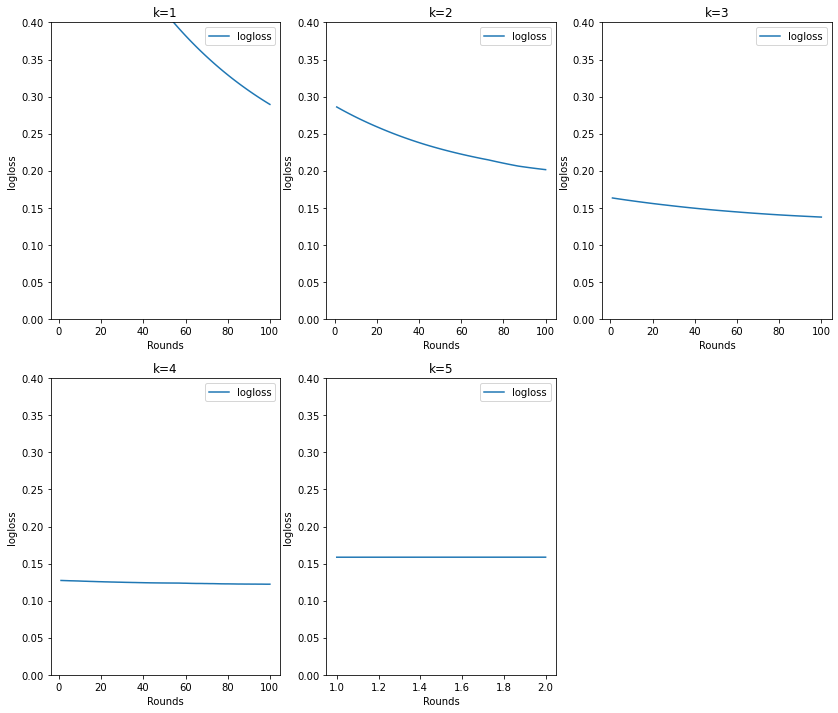

In [532]:
# logloss 그래프
plt.figure(figsize=(14,12))
for info in xgb_train_iter_info:
    logloss_df = pd.DataFrame(info['history']['logloss_list'], columns=['logloss'])
    logloss_df['rounds'] = list(range(1,len(info['history']['logloss_list'])+1))
    
    plt.subplot(2,3,info['xgb_train_iter_index'])
    plt.xlabel('Rounds')
    plt.ylabel('logloss')
    plt.plot(logloss_df['rounds'], logloss_df['logloss'],
           label='logloss')
    plt.title("k={}".format(info['xgb_train_iter_index']))
    plt.ylim([0,0.4])
    plt.legend()
plt.show()

### 5. 평가

In [533]:
xgb = XGBClassifier()
xgb.load_model('models/XGBoost CLF Model ver 1.0.json')

In [534]:
train_x = train_data.loc[:,target_cols].values
train_y = train_data.loc[:,['label_data_er30']].values
test_x = test_data.loc[:,target_cols].values
test_y = test_data.loc[:,['label_data_er30']].values

# 학습 데이터에 대한 예측
xgb_train_predict_value = xgb.predict(train_x)
xgb_train_predict_probs = xgb.predict_proba(train_x)

# 테스트 데이터에 대한 예측
xgb_predict_value = xgb.predict(test_x)
xgb_predict_probs = xgb.predict_proba(test_x)

In [535]:
# 각 분류 별 정확도를 구하기 위한 코드
train_data.loc[:,'xgb_train_predict_value'] = xgb_train_predict_value
test_data.loc[:,'xgb_predict_value'] = xgb_predict_value

In [536]:
# 평가 표 제작
result_df = pd.DataFrame(
    index=[
        '사용 모델','Eval Metric','학습 시간','학습 반복 수','Learning Rate','Early Stopping','Scaling','StratifiedKFold(n_splits)',
        '---------------Train--------------',
        '학습 데이터 수','학습 데이터 정확도 / 수',
        'Logloss','Precision','Recall','F1 Score','AUC',
        '데이터 수 [label:0]','정확도 / 수 [label:0]',
        '데이터 수 [label:1]','정확도 / 수 [label:1]',
        '----------------Test--------------',
        '테스트 데이터 수','테스트 데이터 정확도 / 수',
        'Logloss','Precision','Recall','F1 Score','AUC',
        '테스트 수 [label:0]','테스트 정확도 / 수 [label:0]',
        '테스트 수 [label:1]','테스트 정확도 / 수 [label:1]',
    ],
    columns=[
        'XGBoost Classifier'
    ]
)

In [539]:
result_df.loc['사용 모델','XGBoost Classifier'] = 'XGBoost Classifier'
result_df.loc['Eval Metric','XGBoost Classifier'] = 'logloss'
result_df.loc['학습 시간','XGBoost Classifier'] = '4s'
result_df.loc['학습 반복 수','XGBoost Classifier'] = '410 rounds'
result_df.loc['Learning Rate','XGBoost Classifier'] = 0.01
result_df.loc['Early Stopping','XGBoost Classifier'] = 'Y'
result_df.loc['Scaling','XGBoost Classifier'] = 'N'
result_df.loc['StratifiedKFold(n_splits)','XGBoost Classifier'] = 'Y (5)'

result_df.loc['---------------Train--------------','XGBoost Classifier'] = '-------------------Train------------------'
result_df.loc['학습 데이터 수','XGBoost Classifier'] = len(train_x)
result_df.loc['학습 데이터 정확도 / 수','XGBoost Classifier'] = "{:.1%} / {:}".format(
    round(accuracy_score(train_y.reshape(-1), xgb_train_predict_value),3),
    len(train_data.loc[(train_data['label_data_er30']==0)&(train_data['xgb_train_predict_value']==0)])+
    len(train_data.loc[(train_data['label_data_er30']==1)&(train_data['xgb_train_predict_value']==1)])
)
result_df.loc['Logloss','XGBoost Classifier'] = "{:.3f}".format(round(log_loss(train_y.reshape(-1), xgb_train_predict_probs),3))
result_df.loc['Precision','XGBoost Classifier'] = "{:.3f}".format(round(precision_score(train_y.reshape(-1), xgb_train_predict_value, pos_label=1),3))
result_df.loc['Recall','XGBoost Classifier'] = "{:.3f}".format(round(recall_score(train_y.reshape(-1), xgb_train_predict_value, pos_label=1),3))
result_df.loc['F1 Score','XGBoost Classifier'] = "{:.3f}".format(round(f1_score(train_y.reshape(-1), xgb_train_predict_value, pos_label=1),3))
result_df.loc['AUC','XGBoost Classifier'] = "{:.3f}".format(round(roc_auc_score(train_y.reshape(-1), xgb_train_predict_value),3))

result_df.loc['데이터 수 [label:0]','XGBoost Classifier'] = len(train_data.loc[train_data['label_data_er30']==0,'label_data_er30'])
result_df.loc['정확도 / 수 [label:0]','XGBoost Classifier'] = "{:.1%} / {:}".format(round(accuracy_score(
    train_data.loc[train_data['label_data_er30']==0,'label_data_er30'].values.reshape(-1),
    train_data.loc[train_data['label_data_er30']==0,'xgb_train_predict_value'].values.reshape(-1)
),3), len(train_data.loc[(train_data['label_data_er30']==0)&(train_data['xgb_train_predict_value']==0)]))
result_df.loc['데이터 수 [label:1]','XGBoost Classifier'] = len(train_data.loc[train_data['label_data_er30']==1,'label_data_er30'])
result_df.loc['정확도 / 수 [label:1]','XGBoost Classifier'] = "{:.1%} / {:}".format(round(accuracy_score(
    train_data.loc[train_data['label_data_er30']==1,'label_data_er30'].values.reshape(-1),
    train_data.loc[train_data['label_data_er30']==1,'xgb_train_predict_value'].values.reshape(-1)
),3), len(train_data.loc[(train_data['label_data_er30']==1)&(train_data['xgb_train_predict_value']==1)]))
result_df.loc['----------------Test--------------','XGBoost Classifier'] = '-------------------Test-------------------'
result_df.loc['테스트 데이터 수','XGBoost Classifier'] = len(test_x)
result_df.loc['테스트 데이터 정확도 / 수','XGBoost Classifier'] = "{:.1%} / {:}".format(
    round(accuracy_score(test_y.reshape(-1), xgb_predict_value),3),
    len(test_data.loc[(test_data['label_data_er30']==0)&(test_data['xgb_predict_value']==0)])+
    len(test_data.loc[(test_data['label_data_er30']==1)&(test_data['xgb_predict_value']==1)])
)
result_df.loc['Logloss','XGBoost Classifier'] = "{:.3f}".format(round(log_loss(test_y.reshape(-1), xgb_predict_probs),3))
result_df.loc['Precision','XGBoost Classifier'] = "{:.3f}".format(round(precision_score(test_y.reshape(-1), xgb_predict_value, pos_label=1),3))
result_df.loc['Recall','XGBoost Classifier'] = "{:.3f}".format(round(recall_score(test_y.reshape(-1), xgb_predict_value, pos_label=1),3))
result_df.loc['F1 Score','XGBoost Classifier'] = "{:.3f}".format(round(f1_score(test_y.reshape(-1), xgb_predict_value, pos_label=1),3))
result_df.loc['AUC','XGBoost Classifier'] = "{:.3f}".format(round(roc_auc_score(test_y.reshape(-1), xgb_predict_value),3))

result_df.loc['테스트 수 [label:0]','XGBoost Classifier'] = len(test_data.loc[test_data['label_data_er30']==0,'label_data_er30'])
result_df.loc['테스트 정확도 / 수 [label:0]','XGBoost Classifier'] = "{:.1%} / {:}".format(round(accuracy_score(
    test_data.loc[test_data['label_data_er30']==0,'label_data_er30'].values.reshape(-1),
    test_data.loc[test_data['label_data_er30']==0,'xgb_predict_value'].values.reshape(-1)
),3), len(test_data.loc[(test_data['label_data_er30']==0)&(test_data['xgb_predict_value']==0)]))
result_df.loc['테스트 수 [label:1]','XGBoost Classifier'] = len(test_data.loc[test_data['label_data_er30']==1,'label_data_er30'])
result_df.loc['테스트 정확도 / 수 [label:1]','XGBoost Classifier'] = "{:.1%} / {:}".format(round(accuracy_score(
    test_data.loc[test_data['label_data_er30']==1,'label_data_er30'].values.reshape(-1),
    test_data.loc[test_data['label_data_er30']==1,'xgb_predict_value'].values.reshape(-1)
),3), len(test_data.loc[(test_data['label_data_er30']==1)&(test_data['xgb_predict_value']==1)]))
result_df.to_csv('result_df', index=True)

In [540]:
pd.read_csv('result_df', index_col=0)

,XGBoost Classifier
사용 모델,XGBoost Classifier
Eval Metric,logloss
학습 시간,4s
학습 반복 수,410 rounds
Learning Rate,0.01
Early Stopping,Y
Scaling,N
StratifiedKFold(n_splits),Y (5)
---------------Train--------------,-------------------Train------------------
학습 데이터 수,37629
